## **Introduction to Image Processing, Computer Vision and Deep Learning**
- Project-2
- 2023/12/22

### Table of Contents：
5. **Train a Cat-Dog Classifier Using ResNet50**
    - 5.1 Load the dataset and resize images
    - 5.2 Show the structure of ResNet50 model
    - 5.3 Improve ResNet50 with Random-Erasing  and Compare the accuracies of 2 ResNet50 models on validation dataset
    - 5.4 Use the trained model to run inference and show the predicted class label


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 22 14:38:43 2023
@author: Mr.Jiang
"""
import cv2
import numpy as np
from numpy import zeros, dot, exp, mgrid, pi, ravel, uint8, square
# from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QPlainTextEdit, QLineEdit, QGraphicsView, QGraphicsScene, QFileDialog
# from PyQt5.QtGui import QIcon, QPixmap
# from PyQt5.QtCore import Qt
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import vgg19_bn, resnet50
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision.models as models
from sklearn.model_selection import train_test_split
from IPython.display import display, Image
from PIL import Image as PILImage
import random
import sys
import io


In [ ]:
# run on Kaggle
import os

# Kaggle input / working
os.listdir("/kaggle/working/") # reset
print(os.listdir('/kaggle/input/hw2-q5-inference-dataset/Hw2_Q5_inference_dataset/'))


### **ResNet（Residual Network）**

- **ResNet** 是由微軟研究院於 2015 年提出的一種深度卷積神經網路架構，它**解決了深層網路在訓練時的「梯度消失」與「準確率下降」問題**，使網路可以非常深而不會失效。 

- **核心概念：Residual Learning（殘差學習）**：ResNet 的重點是使用 **「殘差連接（Skip Connection）」** 來讓深層網路更容易訓練。

- **Bottleneck Block 結構（核心 module）**，這個結構讓深層網路在計算成本可控的情況下增加深度，且透過 **skip connection** 把輸入直接加到輸出來形成「殘差」，Skip Connection：`output = F(x) + x`，**讓模型學「差值」而非完整映射**。每個 Block 各包含：

```
1x1 conv (降低維度)
3x3 conv (標準卷積)
1x1 conv (恢復維度)
+ identity skip connection
```

- ResNet50 表示這個網路有 **50 層深**，其中大部分是**卷積層（Conv）**。
    - **1（conv1） + 16 x 3（conv layers per block） + 1（fc）= 50 層**
    - 1 個 Conv1
    - 16 個 Bottleneck blocks（每個 block 有 3 層 conv）
    - 1 個 FC 層

| 區塊 | 功能說明 |
|------|----------|
| Conv1 | 一個 7x7 的卷積 + MaxPooling |
| Conv2_x | 3 個 Bottleneck block，channdel 從 64 開始 |
| Conv3_x | 4 個 Bottleneck block |
| Conv4_x | 6 個 Bottleneck block |
| Conv5_x | 3 個 Bottleneck block |
| AvgPool | Global Average Pooling |
| FC | 全連接層（預設輸出 1000 類別）|

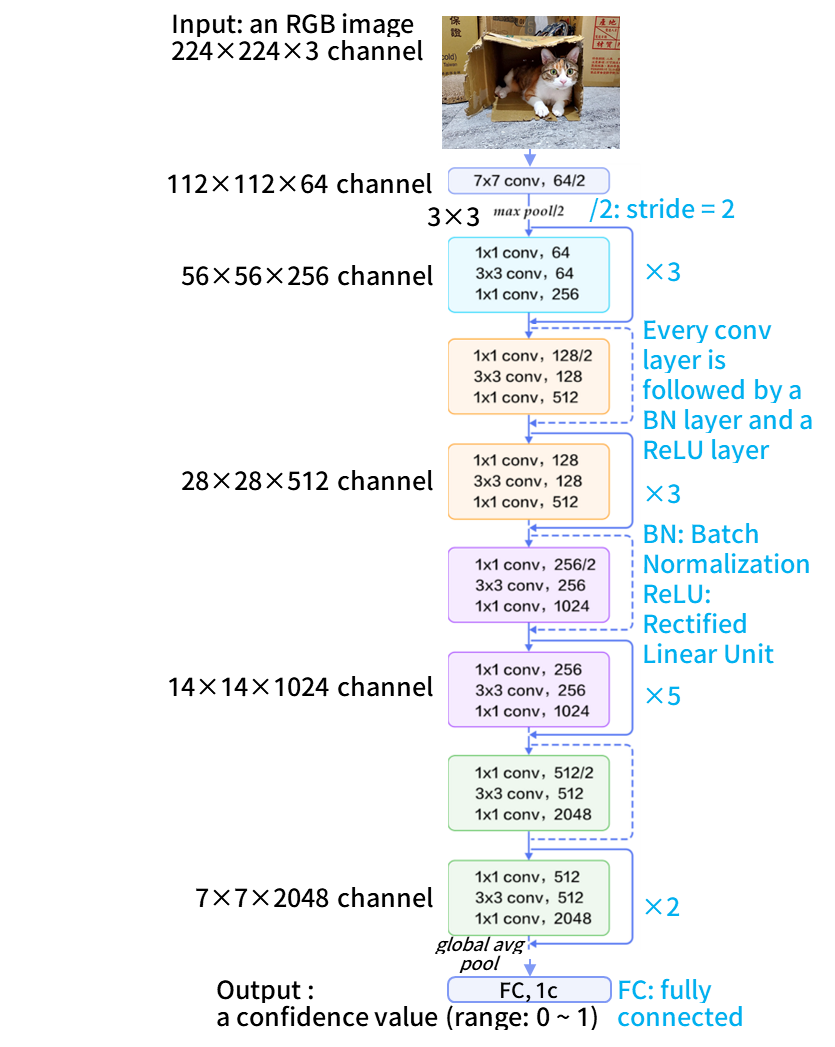

- **ResNet50 的優點**：

| 優點 | 說明 |
|------|------|
| ✔️ 深度可擴展 | 可達 50、101、152 層 |
| ✔️ 殘差學習 | 解決深層訓練困難 |
| ✔️ 效果強 | 在 ImageNet 上表現出色 |
| ✔️ 支援預訓練 | torchvision 可直接載入預訓練權重 |

- **應用**：

    1. 影像分類（Image Classification）
    2. 物件偵測（搭配 Faster R-CNN）
    3. 影像語意分割（Semantic Segmentation）
    4. 特徵提取 backbone
    5. Medical imaging, 衛星影像、手寫辨識


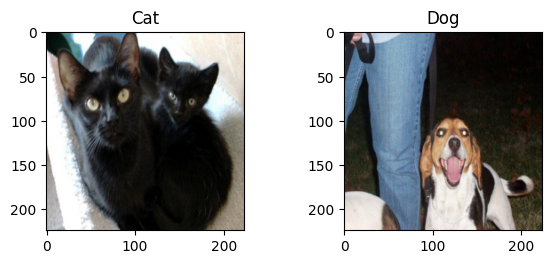

In [14]:
# 5.1 Load the dataset and resize images---------------------------------

class Q51():
    def Load_the_dataset_and_resize_images(self):
        data_root = '/kaggle/input/hw2-q5-inference-dataset/Hw2_Q5_inference_dataset/'

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        # random.choice()
        cat_folder = os.path.join(data_root, "Cat")
        dog_folder = os.path.join(data_root, "Dog")

        cat_image_path = os.path.join(cat_folder, random.choice(os.listdir(cat_folder)))
        dog_image_path = os.path.join(dog_folder, random.choice(os.listdir(dog_folder)))

        cat_image = PILImage.open(cat_image_path).convert("RGB")
        dog_image = PILImage.open(dog_image_path).convert("RGB")

        cat_image = transform(cat_image)
        dog_image = transform(dog_image)

        plt.subplot(1, 2, 1)
        plt.imshow(cat_image.permute(1, 2, 0).numpy())
        plt.title("Cat")

        plt.subplot(1, 2, 2)
        plt.imshow(dog_image.permute(1, 2, 0).numpy())
        plt.title("Dog")
        '''
        permute(1, 2, 0) 用於重新排列 Tensor 的維度
        PyTorch Tensor 順序為 (Channel, Hight, Width)
        matplotlib 的 imshow() 順序為 (Hight, Width, Channel)
        '''
        # adjust (width)horizontal space
        plt.subplots_adjust(wspace=0.5)
        plt.show()

q51 = Q51()
q51.Load_the_dataset_and_resize_images()


In [17]:
# 5.2 Show the structure of ResNet50 model-------------------------------

class Q52():
    def Show_the_structure_of_ResNet50_model(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = resnet50(pretrained=False)

        # original output layer
        print("Original output layer:", model.fc)

        # Replace the output layer -> Linear(2048 → 1) + Sigmoid
        model.fc = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

        print("Replaced output layer:", model.fc)

        model = model.to(device)
        # Display the modified ResNet50 architecture
        summary(model, (3, 224, 224))  # Assuming input images are RGB with size 224x224

q52 = Q52()
q52.Show_the_structure_of_ResNet50_model()


Original output layer: Linear(in_features=2048, out_features=1000, bias=True)
Replaced output layer: Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 

### **各種 Loss Function 對輸入/標籤形狀的要求**

| Loss Function | 用途 | 預測值 `y_pred` 的 shape | 標籤 `y` 的 shape | 備註 |
|---------------|------|---------------------------|-------------------|-------|
| **Binary Cross-Entropy Loss**： `nn.BCELoss()` | **輸出經手動應用 Sigmoid：二元分類** | `(batch_size, 1)`（機率） | `(batch_size, 1)`（0 or 1） | **預測值和目標值的 shape 必須相同**：`y` 需先 `.float().unsqueeze(1)`|
| **Binary Cross-Entropy with Logits Loss**：`nn.BCEWithLogitsLoss()` | **內建 sigmoid 函數：二元分類**（輸出 raw logits） | `(batch_size, 1)`（raw logits） | `(batch_size, 1)`（0 or 1） | 不需手動加 Sigmoid |
| `nn.CrossEntropyLoss()` | **多類別分類** | `(batch_size, num_classes)`（raw logits） | `(batch_size)`（每個值是 class index） | 已內建，不用加 Softmax，loss 會自動處理 |
| **Negative Log Likelihood Loss**：`nn.NLLLoss()` | 多類別分類（輸出已經是 log-softmax） | `(batch_size, num_classes)`（log probs） | `(batch_size)`（class index） | 是 nn.CrossEntropyLoss 的一部分，用於 log-softmax 輸出模型 |

1. **BCELoss / BCEWithLogitsLoss** → 輸入維度 `y` 需要是 `(batch_size, 1)`，而不是`(batch_size)`
    - 常見做法 for BCELoss/BCEWithLogitsLoss，保證 y 是 float 並 shape 對齊：**y = y.to(device).float().unsqueeze(1)**
 
2. **CrossEntropyLoss** → 輸入維度 `y` 要是 `(batch_size)`（一維），值是 class 的 index（例如 0, 1, 2...）
    - CrossEntropyLoss 不用做 unsqueeze，也不用轉 float，labels 是 class index, e.g. 0 or 1 or 2
y = y.to(device).long()

### **Logits 與機率**

| 特性         | Logits                | 機率 (Probability)      |
|--------------|-----------------------|-------------------------|
| 範圍         | 任意實數 (-∞, +∞)     | [0, 1]                 |
| 規範化       | 未規範化              | 規範化（多分類和為 1） |
| 計算方式     | 線性層輸出            | sigmoid 或 softmax 輸出 |
| 數值穩定性   | 可能很大或很小        | 穩定在 0 到 1 之間     |

- 假設一個二分類模型的輸出 logits 是：
    - \( z = 2.0 \)（正類的信心分數）
    - 通過 sigmoid 轉換後：p =  0.88，表示模型預測正類的機率為 88%。

- 假設一個三分類模型的輸出 logits 是：
    - \( z = [1.0, 2.0, 0.5] \)
    - 通過 softmax 轉換後：
        - p_0 = 0.23
        - p_1 = 0.63
        - p_2 = 0.14
    - 表示模型預測三個類別的概率分別為 23%、63% 和 14%。


- **為什麼損失函數偏好 Logits？**

1. **數值穩定性**：
   - 使用 logits，損失函數內部可以通過數學變換（如：log-sum-exp）避免這些問題。

2. **計算效率**：
   - 將激活函數和損失計算合併，可以減少中間步驟，提高計算效率。

3. **梯度計算**：
   - Logits 的梯度計算更直接，適合反向傳播。


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 ------Train Loss: 0.6342 | Train Acc: 67.95%
Epoch 1 --------Val Loss: 0.5835 |   Val Acc: 68.06%
Saved best model at epoch 1  | Val Acc：68.06%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 2  | Val Acc：73.44%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 4  | Val Acc：79.17%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5 ------Train Loss: 0.4173 | Train Acc: 81.04%
Epoch 5 --------Val Loss: 0.5575 |   Val Acc: 76.06%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 7  | Val Acc：80.83%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10------Train Loss: 0.2699 | Train Acc: 89.12%
Epoch 10--------Val Loss: 0.2459 |   Val Acc: 90.83%
Saved best model at epoch 10 | Val Acc：90.83%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 11 | Val Acc：93.28%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 12 | Val Acc：93.61%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 13 | Val Acc：93.83%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15------Train Loss: 0.1418 | Train Acc: 94.28%
Epoch 15--------Val Loss: 0.1431 |   Val Acc: 94.67%
Saved best model at epoch 15 | Val Acc：94.67%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 17 | Val Acc：94.72%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20------Train Loss: 0.1073 | Train Acc: 95.55%
Epoch 20--------Val Loss: 0.1728 |   Val Acc: 93.39%


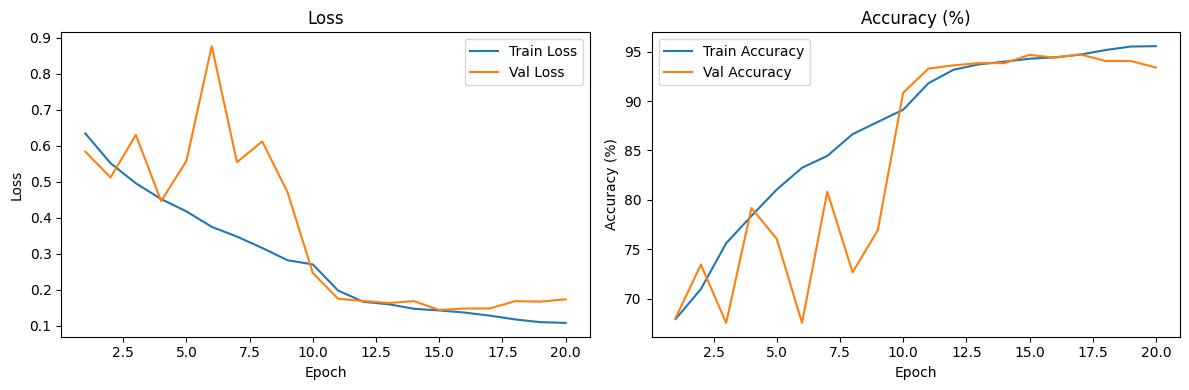

['Best_ResNet50_without_Random_Erasing.pth', 'Best_ResNet50_with_Random_Erasing.pth', '.virtual_documents', 'ResNet50_training_curves_with_Random_Erasing.png']


In [8]:
# 5.3 Compare the accuracies of 2 ResNet50 models on validation dataset----------------------

# 5.3-1 With Random-Erasing-------------------------------

class Q53_1():
    def ResNet50_With_Random_Erasing(self, batch_size, epochs, lr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing

        # Data augmentation for training set
        train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.RandomErasing(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Data augmentation only normalize for val set
        val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        '''
        transforms.CenterCrop() 從圖像的中心位置裁剪出指定大小的區域
            - 中心裁剪可以作為調整圖像尺寸的一部分

        transforms.RandomErasing() 隨機擦除圖像部分區域的資料增強
            - 需要在 Tensor 格式的圖像數據上進行操作，放在 ToTensor()後面
            - 以一定的機率隨機選擇圖像中的一個矩形區域，並用指定的值填充該區域的像素
        '''
        # 自定義一個圖像讀取方式 loader，強制只用 JPEG pil_loader 讀圖（跳過 PIL 自動推斷）
        def pil_loader(path):
            with open(path, 'rb') as f:
                img = PILImage.open(io.BytesIO(f.read()))
                return img.convert('RGB')  # 強制轉 RGB（避免 tiff 等特殊通道）

        # load dataset on kaggle
        data_root = '/kaggle/input/dataset-opencvdl-hw2-q5/Dataset_OpenCvDl_Hw2_Q5/dataset/'
        train_dir = os.path.join(data_root, "training_dataset")
        val_dir = os.path.join(data_root, "validation_dataset")

        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform, loader=pil_loader)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform, loader=pil_loader)
        '''
        torchvision.datasets.ImageFolder 要求資料集的目錄結構長這樣：

        root/
        ├── class1/
        │   ├── img1.jpg
        │   ├── img2.jpg
        │   └── ...
        ├── class2/
        │   ├── img1.jpg
        │   ├── img2.jpg
        │   └── ...
        └── ...

        - 適用於「每個類別都有獨立資料夾」、「想快速建構二分類 / 多分類資料集」

        ImageFolder 本質上是一個自動建構標籤的 Dataset 類別，它會：
            1. 掃描 root 目錄
            2. 每個子資料夾名稱代表一個 class
            3. 給每個 class 配一個整數 label
            4. 回傳 (__getitem__) -> (image_tensor, label_int)

        '''
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers = 4,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers = 4,
            pin_memory=True
        )
        '''
        pin_memory=True 讓 CPU 至 GPU 的 tensor 傳輸變快，減少 bottleneck
        '''

        '''
        DataLoader：
            1. 當資料集總樣本數無法被批次大小整除時，會產生剩餘樣本，DataLoader 預設為捨棄
            2. 標籤資料由 DataLoader 負責轉換為 PyTorch tensor；影像資料則是由 transforms.ToTensor() 轉換
                - DataLoader 會將標籤資料轉換為 PyTorch tensor，以便與影像資料一起傳遞給模型
            3. num_workers 為一個超參數，用於設定資料載入的子程序數量，可以顯著加速資料載入的速度
                - 子程序負責從資料集中讀取資料，並將資料傳遞給主程序（main process）
                - 主程序負責將資料傳遞給模型進行訓練
        '''
        # 2. load Resnet50 with output = FC + sigmoid
        model = resnet50(weights=None)

        model.fc = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

        model = model.to(device)

        # 3. define Loss function and optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 經過每 10 個 epoch，lr 變為原來的 0.1 倍

        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # 4. define train and val
        def train(epoch):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (X, y) in enumerate(train_loader):
                X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True).float().unsqueeze(1)
                '''
                .to(device, non_blocking=True) 搭配 pin_memory=True -> 達到更高效的資料搬運
                '''

                '''
                .float().unsqueeze(1) for 二元分類（輸出經過 Sigmoid）adjust shape to (batch_size, 1)
                '''

                '''
                每個 train_loader 中輸出一個 tuple：
                    1. X：一個 shape 為 (batch_size, channels, height, width) 的 tensor
                    2. y：一個 shape 為 (batch_size) 的 tensor，因為每一筆影像配對一個 label，有幾筆 image = 有幾筆 label
                '''

                # .zero_grad() 將模型所有參數的梯度清零。
                # 是必要的，因為 PyTorch 的梯度會累加，如果不清零，前一批次的梯度會影響當前批次。
                optimizer.zero_grad()

                # Forward Propagation： X (batch_size, channels, height, width) -> y_pred (batch_size, 1)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                # Backward Propagation
                loss.backward() # 梯度會儲存在模型參數的 .grad 屬性中，為後續優化步驟做準備
                optimizer.step()
                '''
                optimizer.step()
                    1. 根據計算出的梯度，使用 Optimizer 更新模型參數
                    2. 對於 SGD，更新規則是：param = param − lr × grad
                '''
                predicted = (y_pred > 0.5).int()
                running_loss += loss.item() # 累積整個 epoch 的 loss

                total += y.size(0) # .size = .shape 回傳 batch_size；total 代表實際有經過 train 的 sample數
                correct += (predicted == y).sum().item() # .item() 用於從單一元素的 tensor 中取得 Python 數值，多元素會 error

            # calculate acc
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for X, y in val_loader:
                    X, y = X.to(device), y.to(device).float().unsqueeze(1)

                    # Forward Propagation： inputs (batch_size, 1) -> outputs (batch_size, prob)
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y) # 注意：這裡計算 loss 僅用於評估，不會用於反向傳播

                    predicted = (y_pred > 0.5).int()
                    running_loss += loss.item()
                    total += y.size(0)
                    correct += (predicted == y).sum().item()

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = 100. * correct / total
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_ResNet50_with_Random_Erasing.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

        # 5. trainng
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)
            scheduler.step()

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('ResNet50_training_curves_with_Random_Erasing.png')
        plt.show()

q53_1 = Q53_1()
q53_1.ResNet50_With_Random_Erasing(128, 20, 0.001)
print(os.listdir("/kaggle/working/"))


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 ------Train Loss: 0.8093 | Train Acc: 66.54%
Epoch 1 --------Val Loss: 0.5657 |   Val Acc: 69.94%
Saved best model at epoch 1  | Val Acc：69.94%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 2  | Val Acc：71.33%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 3  | Val Acc：74.22%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 4  | Val Acc：80.89%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5 ------Train Loss: 0.4011 | Train Acc: 81.88%
Epoch 5 --------Val Loss: 0.4408 |   Val Acc: 80.11%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 6  | Val Acc：84.56%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 7  | Val Acc：85.22%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 8  | Val Acc：86.50%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 9  | Val Acc：90.33%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10------Train Loss: 0.2016 | Train Acc: 91.81%
Epoch 10--------Val Loss: 0.2414 |   Val Acc: 90.39%
Saved best model at epoch 10 | Val Acc：90.39%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 11 | Val Acc：94.61%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 12 | Val Acc：95.00%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15------Train Loss: 0.0754 | Train Acc: 97.14%
Epoch 15--------Val Loss: 0.1329 |   Val Acc: 94.89%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model at epoch 17 | Val Acc：95.06%


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20------Train Loss: 0.0407 | Train Acc: 98.54%
Epoch 20--------Val Loss: 0.1639 |   Val Acc: 95.33%
Saved best model at epoch 20 | Val Acc：95.33%


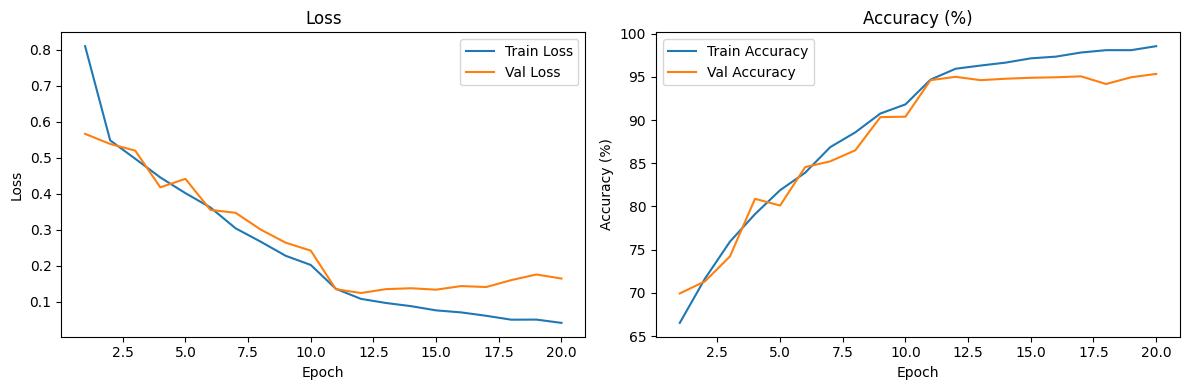

['Best_ResNet50_without_Random_Erasing.pth', 'Best_ResNet50_with_Random_Erasing.pth', '.virtual_documents', 'ResNet50_training_curves_with_Random_Erasing.png', 'ResNet50_training_curves_without_Random_Erasing.png']


In [9]:
# 5.3 Compare the accuracies of 2 ResNet50 models on validation dataset----------------------

# 5.3-2 Without Random-Erasing-------------------------------

class Q53_2():
    def ResNet50_Without_Random_Erasing(self, batch_size, epochs, lr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing

        # Data augmentation for training set
        train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Data augmentation only normalize for val set
        val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        '''
        transforms.CenterCrop() 從圖像的中心位置裁剪出指定大小的區域
            - 中心裁剪可以作為調整圖像尺寸的一部分

        transforms.RandomErasing() 隨機擦除圖像部分區域的資料增強
            - 需要在 Tensor 格式的圖像數據上進行操作，放在 ToTensor()後面
            - 以一定的機率隨機選擇圖像中的一個矩形區域，並用指定的值填充該區域的像素
        '''
        # 自定義一個圖像讀取方式 loader，強制只用 JPEG pil_loader 讀圖（跳過 PIL 自動推斷）
        def pil_loader(path):
            with open(path, 'rb') as f:
                img = PILImage.open(io.BytesIO(f.read()))
                return img.convert('RGB')  # 強制轉 RGB（避免 tiff 等特殊通道）

        # load dataset on kaggle
        data_root = '/kaggle/input/dataset-opencvdl-hw2-q5/Dataset_OpenCvDl_Hw2_Q5/dataset/'
        train_dir = os.path.join(data_root, "training_dataset")
        val_dir = os.path.join(data_root, "validation_dataset")

        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform, loader=pil_loader)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform, loader=pil_loader)
        '''
        torchvision.datasets.ImageFolder 要求資料集的目錄結構長這樣：

        root/
        ├── class1/
        │   ├── img1.jpg
        │   ├── img2.jpg
        │   └── ...
        ├── class2/
        │   ├── img1.jpg
        │   ├── img2.jpg
        │   └── ...
        └── ...

        - 適用於「每個類別都有獨立資料夾」、「想快速建構二分類 / 多分類資料集」

        ImageFolder 本質上是一個自動建構標籤的 Dataset 類別，它會：
            1. 掃描 root 目錄
            2. 每個子資料夾名稱代表一個 class
            3. 給每個 class 配一個整數 label
            4. 回傳 (__getitem__) -> (image_tensor, label_int)

        '''
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers = 4,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers = 4,
            pin_memory=True
        )
        '''
        pin_memory=True 讓 CPU 至 GPU 的 tensor 傳輸變快，減少 bottleneck
        '''

        '''
        DataLoader：
            1. 當資料集總樣本數無法被批次大小整除時，會產生剩餘樣本，DataLoader 預設為捨棄
            2. 標籤資料由 DataLoader 負責轉換為 PyTorch tensor；影像資料則是由 transforms.ToTensor() 轉換
                - DataLoader 會將標籤資料轉換為 PyTorch tensor，以便與影像資料一起傳遞給模型
            3. num_workers 為一個超參數，用於設定資料載入的子程序數量，可以顯著加速資料載入的速度
                - 子程序負責從資料集中讀取資料，並將資料傳遞給主程序（main process）
                - 主程序負責將資料傳遞給模型進行訓練
        '''
        # 2. load Resnet50 with output = FC + sigmoid
        model = resnet50(weights=None)

        model.fc = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

        model = model.to(device)

        # 3. define Loss function and optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 經過每 10 個 epoch，lr 變為原來的 0.1 倍

        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # 4. define train and val
        def train(epoch):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (X, y) in enumerate(train_loader):
                X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True).float().unsqueeze(1)
                '''
                .to(device, non_blocking=True) 搭配 pin_memory=True -> 達到更高效的資料搬運
                '''

                '''
                .float().unsqueeze(1) for 二元分類（輸出經過 Sigmoid）adjust shape to (batch_size, 1)
                '''

                '''
                每個 train_loader 中輸出一個 tuple：
                    1. X：一個 shape 為 (batch_size, channels, height, width) 的 tensor
                    2. y：一個 shape 為 (batch_size) 的 tensor，因為每一筆影像配對一個 label，有幾筆 image = 有幾筆 label
                '''

                # .zero_grad() 將模型所有參數的梯度清零。
                # 是必要的，因為 PyTorch 的梯度會累加，如果不清零，前一批次的梯度會影響當前批次。
                optimizer.zero_grad()

                # Forward Propagation： X (batch_size, channels, height, width) -> y_pred (batch_size, 1)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                # Backward Propagation
                loss.backward() # 梯度會儲存在模型參數的 .grad 屬性中，為後續優化步驟做準備
                optimizer.step()
                '''
                optimizer.step()
                    1. 根據計算出的梯度，使用 Optimizer 更新模型參數
                    2. 對於 SGD，更新規則是：param = param − lr × grad
                '''
                predicted = (y_pred > 0.5).int()
                running_loss += loss.item() # 累積整個 epoch 的 loss

                total += y.size(0) # .size = .shape 回傳 batch_size；total 代表實際有經過 train 的 sample數
                correct += (predicted == y).sum().item() # .item() 用於從單一元素的 tensor 中取得 Python 數值，多元素會 error

            # calculate acc
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for X, y in val_loader:
                    X, y = X.to(device), y.to(device).float().unsqueeze(1)

                    # Forward Propagation： inputs (batch_size, 1) -> outputs (batch_size, prob)
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y) # 注意：這裡計算 loss 僅用於評估，不會用於反向傳播

                    predicted = (y_pred > 0.5).int()
                    running_loss += loss.item()
                    total += y.size(0)
                    correct += (predicted == y).sum().item()

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = 100. * correct / total
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_ResNet50_without_Random_Erasing.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

        # 5. trainng
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)
            scheduler.step()

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('ResNet50_training_curves_without_Random_Erasing.png')
        plt.show()

q53_2 = Q53_2()
q53_2.ResNet50_Without_Random_Erasing(128, 20, 0.001)
print(os.listdir("/kaggle/working/"))


Predicted Class: Dog


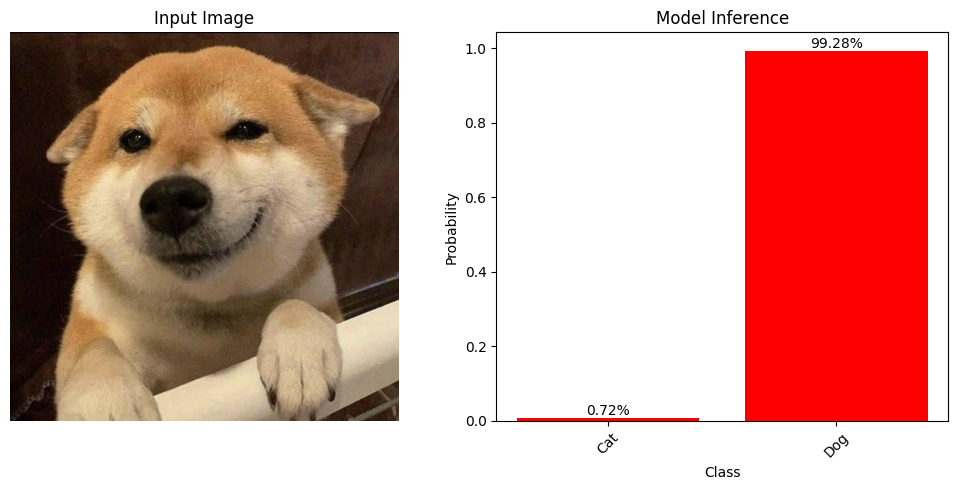

In [84]:
# 5.4 Use the better-trained model to run inference-------------------------------------------------

class Q54():
    def Run_Inference(self):

        model_path = "Best_ResNet50_with_Random_Erasing.pth"
        model = resnet50(weights=None)

        model.fc = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

        # state_dict 為 model weights and bias
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]) # 如果不做 Normalize，輸入的數據分佈與模型訓練時的不同，會導致輸出錯誤

        image_path = "Hw2_Q5_inference_dataset"
        sub_dirs = ['Cat', 'Dog']

        selected_dir = random.choice(sub_dirs)
        selected_dir_path = os.path.join(image_path, selected_dir)

        image_files = [f for f in os.listdir(selected_dir_path) if f.endswith('.jpg')]
        selected_image = random.choice(image_files)

        selected_image_path = os.path.join(selected_dir_path, selected_image)
        image = PILImage.open(selected_image_path).convert("RGB")

        image_tensor = transform(image).unsqueeze(0) # [3,244,244] -> [1,3,244,244] mean batch_size = 1
        class_dic = {0:'Cat', 1:'Dog'}

        # inference
        with torch.no_grad():

            output = model(image_tensor)

            dog_prob = output.item()
            cat_prob = 1 - dog_prob

            predicted = (output > 0.5).int().item()
            predicted_class = class_dic[predicted]

        # display
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Input Image")

        print(f"Predicted Class: {predicted_class}")
        plt.subplot(1, 2, 2)
        bars = plt.bar([value for value in class_dic.values()], [cat_prob, dog_prob], color="red")
        for bar in bars:
            height = bar.get_height()  # 獲取柱子高度 = 即概率值
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # x 位置：柱子中心
                height,                             # y 位置：柱子頂部
                f'{height:.2%}',                   # 文字內容：概率值（百分比格式）
                ha='center',                       # 水平對齊：居中
                va='bottom'                        # 垂直對齊：底部（文字在柱子上方）
            )
        plt.xlabel("Class")
        plt.ylabel("Probability")
        plt.title("Model Inference")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

q54 = Q54()
q54.Run_Inference()
